### analysis ideas:
- show that it is integrating (something about slow eigenmodes)
- see how the network responds to inputs outside of training
    - longer timescale for output
    - different length stimulus
- calculate fixed points across partitions, even outside of current partition
- calculate distance to the good fixed points



### training ideas:
- overtrain a lot to get more stable solution
- train using many more coherences
- decide on whether to use input/recurrent noise
- try fewer neurons
- daniel: increase spectral radius
- correlated recurrent noise?


### task ideas
- mask more time to give delay
- make task even harder


### backend todo:
- add curriculum learning
- add saving weights during training

# Import

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sisyphus2.backend import analysis, visualizations, simulation_tools
from sisyphus2.backend.networks import Model
from sisyphus2.tasks import task

In [2]:
rdm = task.rdm2(stim_noise = 0.02, coherences = [0.005], rec_noise = .01, N_rec = 5)

In [3]:
gen = rdm.generate_train_trials()

In [4]:
params = rdm.__dict__

In [108]:
rdm = task.rdm2(stim_noise = 0.1, coherences = np.linspace(.01, .2, 100), rec_noise = .01, N_rec = 5)

# Load Weights

In [5]:
weights_path = '../weights/rdm_5_rec.npz'

In [116]:
weights_path = '../weights/rdm_4_rec.npz'

In [51]:
weights_path = '../weights/rdm_10_rec.npz'

In [5]:
weights_path = '../weights/rdm_david.npz'

# Generate Trials

In [27]:
sim = simulation_tools.Simulator(params, weights_path=weights_path)
dat = gen.next()
trial = dat[0][0,:,:]
result = dat[1][0,:,:]

In [9]:
trial = np.vstack((trial, np.zeros((1000,2))))

In [28]:
output,states = sim.run_trial(trial)

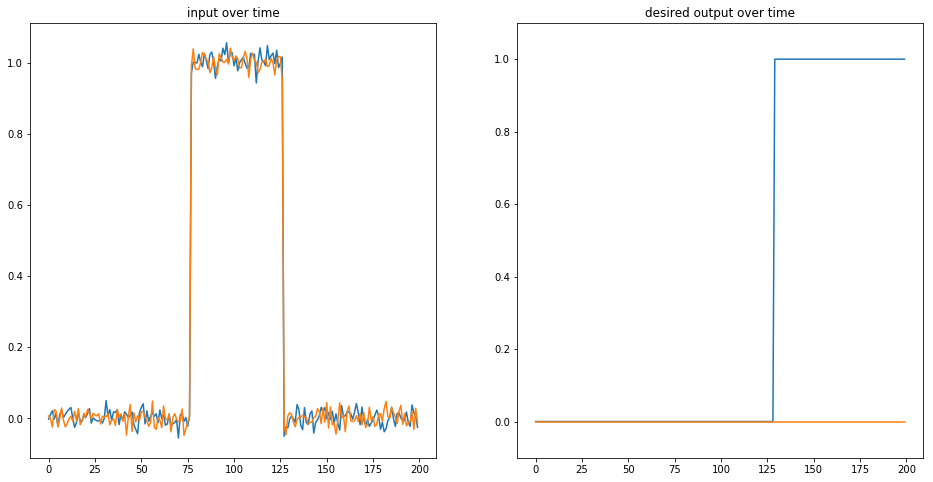

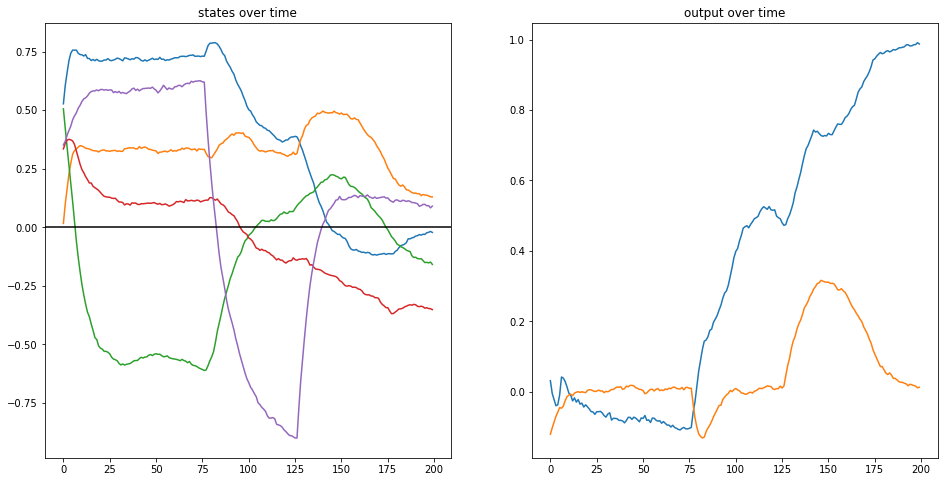

In [29]:

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(trial)
plt.title("input over time")

plt.subplot(1,2,2)
plt.plot(result)
plt.ylim(-0.1, 1.1)
plt.title("desired output over time")

plt.show()

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(states[:,0,:])
plt.axhline(y=0, color='k')
plt.title("states over time")

plt.subplot(1,2,2)
plt.plot(output[:,0,:])
plt.title("output over time")
plt.show()

In [26]:
analysis.hahnloser_fixed_point(sim, trial)

[ 0.01341738  0.02680961]
[-0.00413896  0.00242206]
[ 0.02811611  0.01262232]
[ 0.01268827 -0.02506498]
[ 0.00957698  0.01708383]
[-0.00644612  0.04446418]
[ 0.00337651 -0.00996186]
[ 0.00579128  0.02525893]
[-0.02447644 -0.02493367]
[-0.00044141  0.02054472]
[ 0.01090969  0.02218434]
[ 0.00395344  0.00921953]
[ 0.02496357 -0.01429073]
[ 0.02377192 -0.00180007]
[-0.01130803  0.01446564]
[-0.0172604  -0.02743219]
[ 0.05736685 -0.02774832]
[ 0.02863059 -0.03341474]
[-0.02186867  0.03433985]
[-0.04855754  0.02127717]
[-0.01580367  0.01056351]
[-0.00884154  0.00840001]
[ 0.00699046 -0.00129174]
[ 0.00420804  0.02674983]
[ 0.00474476 -0.00308287]
[-0.00032259 -0.04355134]
[-0.00314518  0.01313122]
[-0.00023495  0.01037167]
[-0.00574284 -0.02630434]
[ 0.03071683  0.01576533]
[-0.03115621 -0.00980936]
[-0.02557177 -0.01765408]
[ 0.01443215  0.01076121]
[-0.00817389  0.00581895]
[ 0.00984719 -0.02823497]
[ 0.00713956  0.04145965]
[-0.01135792 -0.00057001]
[ 0.00105779 -0.00273382]
[ 0.02717403

[array([-0.02966952, -0.21793071, -0.02259756, -0.17683487,  0.64214768]),
 array([-0.06421773, -0.14596148, -0.04441075, -0.18315406,  0.61041525]),
 array([-0.02944721, -0.22082931, -0.02157333, -0.17235978,  0.64189328]),
 array([-0.07329037, -0.13064139, -0.04884   , -0.17829595,  0.60140804]),
 array([-0.04086892, -0.19490969, -0.02955653, -0.17832066,  0.63180287]),
 array([-0.03122885, -0.21149793, -0.02473776, -0.18291817,  0.64131505]),
 array([-0.06835897, -0.13894095, -0.04644252, -0.18098684,  0.60630907]),
 array([-0.03717624, -0.20165665, -0.02756814, -0.17936669,  0.63537262]),
 array([-0.10349636, -0.06407505, -0.06923352, -0.19045319,  0.5743498 ]),
 array([-0.04617027, -0.18264314, -0.03334756, -0.18151713,  0.62716388]),
 array([-0.03555135, -0.20575832, -0.02628209, -0.1777644 ,  0.6367301 ]),
 array([-0.05197884, -0.17176972, -0.03656981, -0.18034603,  0.62159775]),
 array([-0.05434108, -0.17055747, -0.03671539, -0.17402555,  0.61872971]),
 array([-0.04495303, -0.1

In [11]:
sim.W_rec

array([[ 0.92765075,  0.16315955, -0.74363202, -1.08248019],
       [-0.23615766, -0.65814942,  1.15642083, -1.00409651],
       [-0.96886259,  0.3102026 ,  0.3764306 , -1.47660911],
       [-0.85208613, -0.1388205 ,  0.00819291,  0.62426376]], dtype=float32)

In [65]:
sim.W_out

array([[ 0.14760181, -1.80095565, -1.66495442]], dtype=float32)

# Daniel's old tests (only noise input, etc)

In [15]:
def plot_response_test(sim, x_test):
    
    n_trials = x_test.shape[0]
    choice = np.zeros(n_trials)
    resp = np.zeros(n_trials)

    for ii in range(n_trials):
        o,s = sim.run_trial(x_test[ii,:,:])
        resp[ii] = o[-1,0,0]
        choice[ii] = np.sign(resp[ii] - .5)
        
    mean_up = np.mean(x_test[choice==1,:,:],axis=0)
    mean_down = np.mean(x_test[choice==-1,:,:],axis=0)
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(mean_up)
    plt.title('Average Up')
    plt.subplot(1,2,2)
    plt.plot(mean_down)
    plt.title('Average Down')
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.bar([0,1],[np.mean(choice==1),np.mean(choice==-1)])
    plt.xticks([.35,1.45],['Up','Down'])
    plt.xlabel('Percent Up')
    plt.subplot(1,2,2)
    plt.hist(resp,20)
    plt.title('Response Histogram')
    plt.show()
    
    return mean_up,mean_down,choice,resp

def coherence_test(sim,cohs = [.2,.1,.05,.04,.02],n_hidden=10,sigma_in = 0):
    
    n_cohs = len(cohs)
    a = np.zeros([200,1])
    a[40:140] = 1
    o = np.zeros([200,n_cohs])
    s = np.zeros([200,n_hidden,n_cohs])
    ev = np.zeros([200,n_cohs])
    for ii,coh in enumerate(cohs): 
        inp = coh*a + sigma_in*np.random.randn(len(a),1)
        o_temp,s_temp = sim.run_trial(inp,t_connectivity=False)
        o[:,ii] = o_temp[:,0,:].flatten()
        s[:,:,ii] = s_temp[:,0,:]
        ev[:,ii] = np.cumsum(coh*a)

    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(o)
    plt.title('output')
    
    plt.subplot(1,2,2)
    plt.plot(ev)
    plt.title('sum of evidence')
    
    plt.show()
    
    return o,s

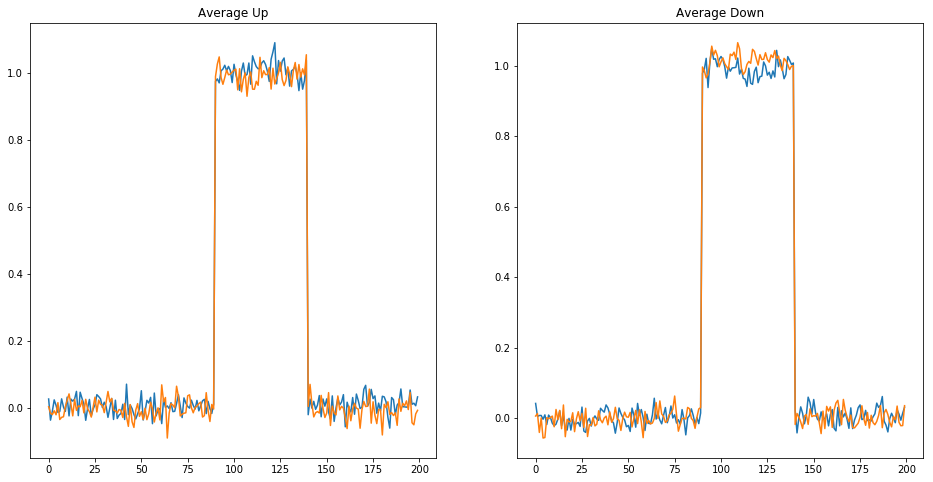

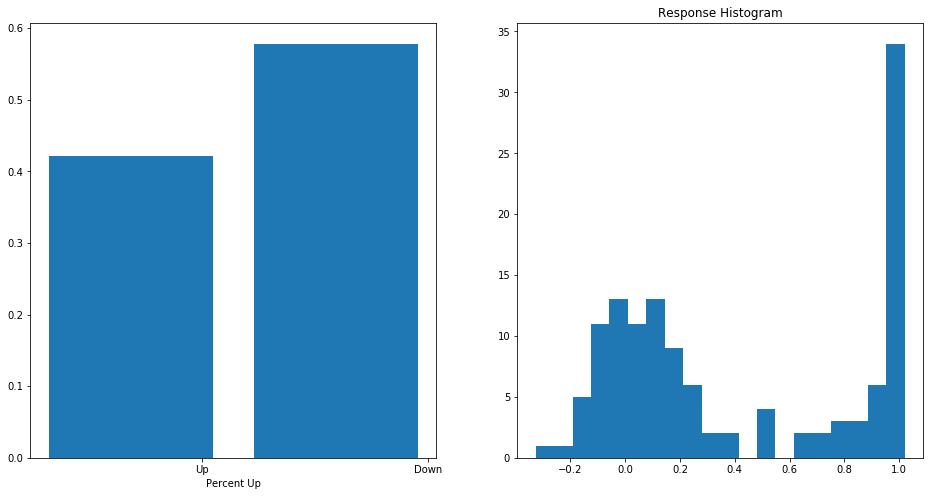

In [16]:
rdm2 = task.rdm2(stim_noise = 0.2, coherences = [0], rec_noise = .01, N_rec = 10)
gen2 = rdm2.generate_train_trials()


a = plot_response_test(sim, gen2.next()[0])
#b = coherence_test(sim, cohs = np.linspace(-.2, .2, 20), n_hidden = 10)

# Distance to fixed point

In [17]:
def distance_to_fixed(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))

    dists = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
        
        #find fixed point at this time step
        # (even if it is outside the current partition)
        fixed_point = -1 * np.matmul(np.linalg.inv(Wp), sim.b_rec + input_mat[:,i])
        
        #calculate distance to fixed point
        d = np.linalg.norm(fixed_point - s)
        dists.append(d)
                       
    # plot results

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,8))
    ax1.plot(dists)
    ax1.set_title('Distance to Fixed Point')
    ax4.plot(np.transpose(input_mat))
    ax3.plot(states[:,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()

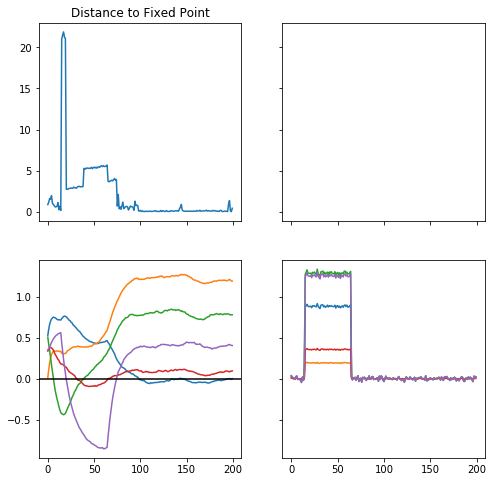

In [18]:
distance_to_fixed(sim, trial)

# Distance to Final Fixed Point

In [94]:
# for rdm_10_rec
fp1 = [ 0.70322314, -0.21220454,  0.42586755,  0.45786433,  0.86620442,
        -0.07819017, -0.18917653, -0.14375263,  0.57091555, -0.9131199 ]
fp2 = [-0.21374657,  0.4618243 , -0.46038991,  0.43066988, -0.42712579,
        -0.43483795,  0.30266692,  0.58161119, -0.16717428, -0.01333921]
fp3 = [-0.13135733, -0.09012359,  0.04480331, -0.11539256, -0.04676911,
         0.37516717, -0.04543317, -0.0355923 , -0.07917503,  0.08330037]

In [17]:
# for rdm_5_rec
fp1 = [ 0.36320676,  0.61929652,  1.30060302,  1.25145486, -3.07111575]
fp2 = [-0.88723986,  0.94818675, -0.29864507,  0.32246673, -0.94195069]
fp3 = [-0.0601163 , -0.1548662 , -0.04169023, -0.18174691,  0.61411446]

In [18]:
def fp_dists(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))

    dists1 = []
    dists2 = []
    dists3 = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
        
        #find fixed point at this time step
        # (even if it is outside the current partition)
        fixed_point = -1 * np.matmul(np.linalg.inv(Wp), sim.b_rec + input_mat[:,i])
        
        #calculate distance to fixed point
        d = np.linalg.norm(fp1 - s)
        dists1.append(d)
        
        d = np.linalg.norm(fp2 - s)
        dists2.append(d)
        
        d = np.linalg.norm(fp3 - s)
        dists3.append(d)
                       
    # plot results

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,8))
    ax1.plot(dists1)
    ax1.set_title('Distance to Fixed Point 1')
    ax2.plot(dists2)
    ax2.set_title('Distance to Fixed Point 2')
    ax4.plot(dists3)
    ax3.plot(states[:,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()

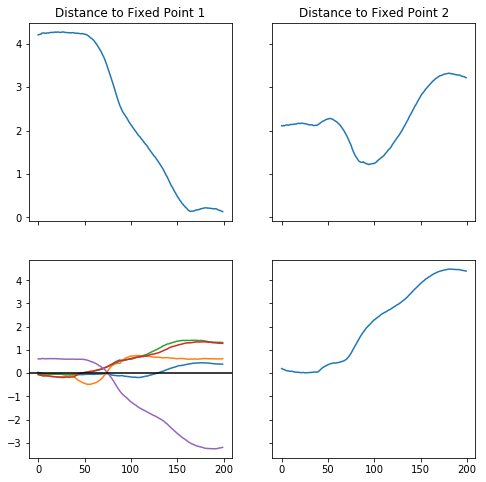

In [19]:
fp_dists(sim, trial)

# Plot eigenvalues

In [19]:
def plot_eigvals(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))

    vals = []
    proj = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
        
        #find eigenvals (real part) at this time step
        l, v = np.linalg.eig(Wp)
        vals.append(np.real(l))
        
        # project 
        proj_s = np.matmul(v, np.transpose(s))
        proj.append(np.transpose(proj_s))
                       
    # plot results

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,12))
    ax1.plot(vals[:])
    ax1.set_title('Eigenvalues')
    ax1.axhline(y=0, color='k')
    ax2.axhline(y=0, color='k')
    ax2.plot(np.array(proj)[:,0,:])
    ax2.set_title('Eigenbasis projection')
    ax4.plot(np.transpose(input_mat))
    ax3.plot(states[:,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()

//anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


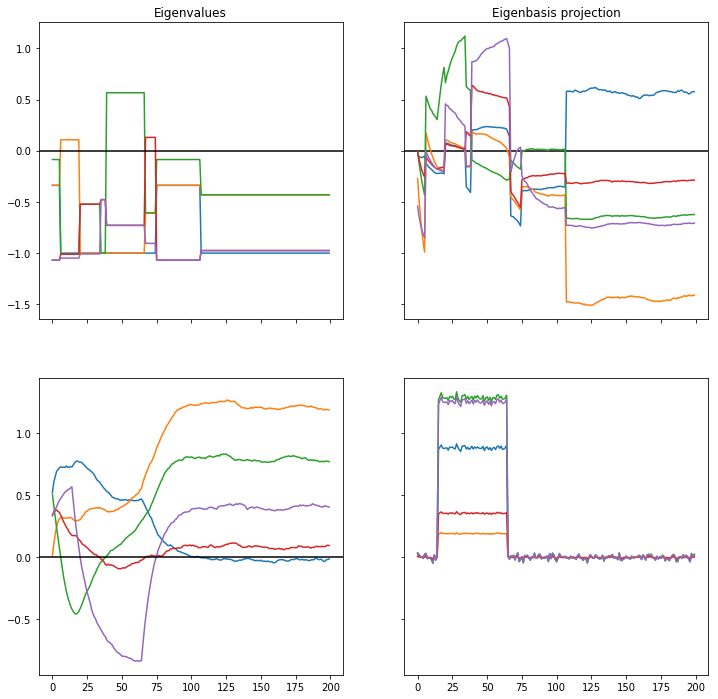

In [20]:
plot_eigvals(sim, trial)

# Project onto all eigenmodes

In [69]:
def project_to_eigenvecs(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))
    
    proj = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
           
        # project onto eigenvals
        vals, vecs = np.linalg.eig(Wp)
        proj_s = np.matmul(vecs, np.transpose(s))
        
        proj.append(np.transpose(proj_s))
       
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,8))
    ax1.plot(np.array(proj)[45:100,0,:])
    ax1.set_title('Eigenvalue projection')
    ax4.plot(np.transpose(input_mat))
    ax3.plot(states[45:100,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()

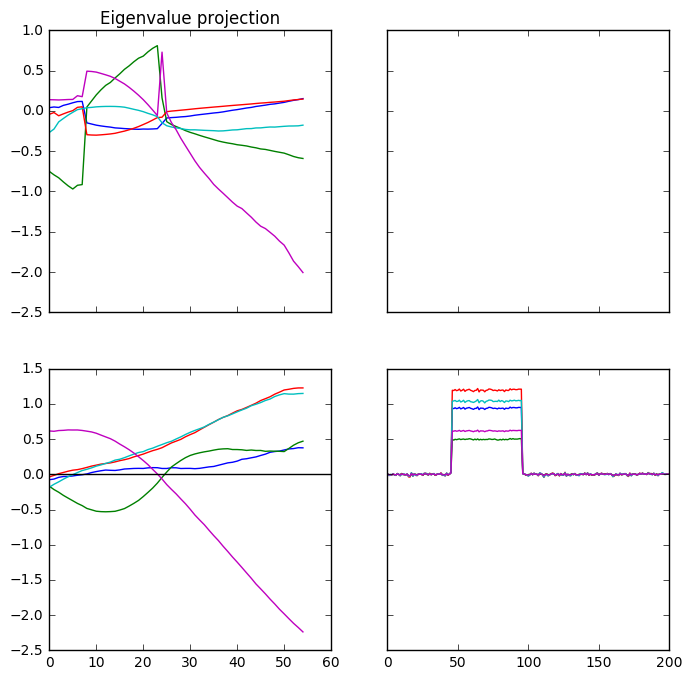

In [70]:
project_to_eigenvecs(sim, trial)

# Slow modes?

In [111]:
def slow_modes_analysis(sim, trial):
    outputs, states = sim.run_trial(trial)

    input_mat = np.matmul(np.absolute(sim.W_in), np.transpose(trial))

    #set identity matrix of proper size
    identity = np.diag(np.ones(sim.N_rec))
    

    proj = []
    for i, s in enumerate(states):
        # define active weight matrix
        Wp = np.copy(sim.W_rec)
        for index in range(sim.N_rec):
            if s[0,index] < 0:
                Wp[:, index] = 0
        Wp = Wp - identity
                
        #find slowest eigenmode
        vals, vecs = np.linalg.eig(Wp)
        slow_idx = np.argmin(np.real(vals))
        
        #if i == 1:
         #   print vals
         #   print vecs
        
        slow_val = vals[slow_idx]
        slow_vec = vecs[:,slow_idx]
        
        #project onto the slow mode
        projected_state = np.dot(s, slow_vec)/np.linalg.norm(slow_vec)
        proj.append(projected_state)
        
        
        
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,8))
    ax1.plot(proj)
    ax1.set_title('Slow Mode')
    ax4.plot(np.transpose(input_mat))
    ax3.plot(states[:,0,:])
    ax3.axhline(y=0, color='k')
    plt.show()
    

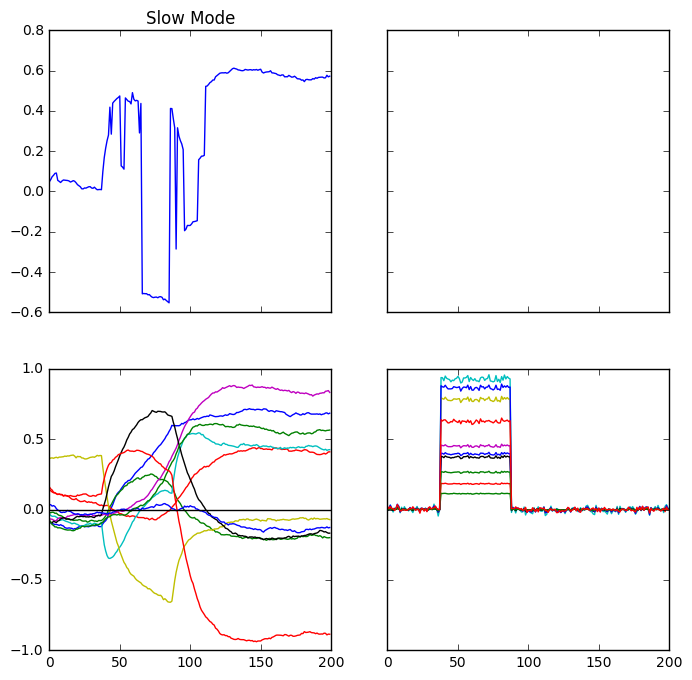

In [112]:
slow_modes_analysis(sim, trial)

In [36]:
sim.W_rec

array([[-0.        ,  0.48333243, -0.27838606],
       [ 1.15871501, -0.        ,  0.89962065],
       [-2.52069807,  1.13063204,  0.        ]], dtype=float32)